In [1]:
import tensorflow as tf

# 0 、文件位置

In [2]:
trainset_path = "./image/train"
testset_path = "./image/test"
output_path = "./output"

image_width = 224
image_height = 224
image_channels = 3

#总共3类
num_breed = 3

# 一、创建 TFRecords文件

In [3]:
import glob
import os
from itertools import groupby
from scipy import misc
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

In [4]:
# class 信息
breeds_with_path = glob.glob(trainset_path + "/*")
breeds = list(map(lambda x:x.split("/")[3],breeds_with_path))
breeds_dict = dict(zip(breeds, [x for x in range(len(breeds))]))

In [5]:
def create_record(dataset_path,output_location):
    # 获取数据集下所有文件路径
    dataset_files = glob.glob(dataset_path + "/*/*.jpg")
    # 分离出claess信息,得到（class,file_path）对的列表
    image_filepath_with_breed = list(map(lambda file_path:(file_path.split("/")[3],file_path),dataset_files))
    
    #每个TFRecord文件保存10个图片
    nums_per_file = 10
    writer = None
    
    # 记录当前读到的图像index
    current_index = 0
    for breed, file_path in image_filepath_with_breed:
        if current_index % nums_per_file == 0:
            if writer:
                print("current_index = ",current_index,"\n")
                writer.close()
            
            # 格式化字符串
            record_filename = "{output_location}{current_index}.tfrecords".format(
            output_location = output_location,
            current_index = current_index)
            
            writer = tf.python_io.TFRecordWriter(record_filename)
            
        current_index += 1
        
        # 读取图像并转换为tf.example格式
        image = misc.imread(file_path)
            
        # 图像转换为Byte型
        image_raw = image.tobytes()
        
        example = tf.train.Example(features = 
                                  tf.train.Features(feature = {
                    "label": tf.train.Feature(int64_list = tf.train.Int64List(value = [breeds_dict[breed]])),
                    "image_raw": tf.train.Feature(bytes_list = tf.train.BytesList(value = [image_raw]))   
                }     
            )    
        )
        
        # 写入文件
        writer.write(example.SerializeToString())
        
    # 关闭最后一个文件
    writer.close()

In [6]:
#create_record(trainset_path,output_path + "/training-images/")
#create_record(testset_path,output_path + "/testing-images/")
print("finished\n")

finished



# 二、 读取TFRecord 文件

In [21]:
filenames =tf.train.match_filenames_once(output_path + "/training-images/*.tfrecords")
#["/home/lile/ML_learning/ML_framework/output/training-images/10.tfrecords","/home/lile/ML_learning/ML_framework/output/training-images/0.tfrecords"] #
filenames_queue = tf.train.string_input_producer(filenames, shuffle = True)

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filenames_queue)
features = tf.parse_single_example(
    serialized_example,
    features = {
        "label":tf.FixedLenFeature([],tf.int64),
        "image_raw":tf.FixedLenFeature([],tf.string)
    }
)

# 解码图像数据
im = tf.decode_raw(features["image_raw"],tf.uint8) 
image = tf.reshape(im,(image_height,image_width,image_channels))
lab = tf.cast(features["label"],tf.int32)
label = tf.one_hot(indices = lab, depth = num_breed,
                   on_value = 1.0, off_value = 0.0,
                   axis = -1)

# 组合训练数据
batch_size = 3
min_after_dequeue = 100*batch_size
capacity = min_after_dequeue + 3*batch_size

image_batch, label_batch = tf.train.shuffle_batch(
(image,label),batch_size = batch_size,
capacity = capacity,min_after_dequeue = min_after_dequeue
)
init = [tf.global_variables_initializer(),tf.local_variables_initializer()]

# 三、定义网络模型

In [22]:
###### 各层图片尺寸 
# input   [batch_size, 224, 224, 3]
# conv1   [32, 56, 56, 64]
# pool1   [32, 27, 27, 64]
# conv2   [32, 27, 27, 192]
# pool2   [32, 13, 13, 192]
# conv3   [32, 13, 13, 384]
# conv4   [32, 13, 13, 256]
# conv5   [32, 13, 13, 256]
# pool5   [32, 6, 6, 256]


# 定义w,b初始化函数
def weights_initializer(shape, stddev = 0.1):
    weights = tf.Variable(tf.truncated_normal(shape,stddev = stddev))
    return weights

def bias_initializer(shape,constant = 0.0):
    bias = tf.Variable(tf.constant(constant, shape =shape, dtype = tf.float32))
    return bias

def fc_weights_initializer(num_in, num_out, stddev = 0.1, constant = 0.0):
    weight = tf.Variable(tf.truncated_normal(shape = [num_in, num_out],stddev = stddev))
    bias = tf.Variable(tf.constant(constant, shape =[1, num_out], dtype = tf.float32))
    return weight, bias

#def interface(x):
    # 输入层
with tf.name_scope("input") as scope:
    x = tf.placeholder(tf.float32,shape = [None, image_height, image_width, image_channels])
    y = tf.placeholder(tf.float32,shape = [None,num_breed])

    #卷积层一
with tf.name_scope("conv1") as scope:
    # 按《TensorFlow 实战》 中为编写，下同
    # 实际 96核
    w = weights_initializer(shape = [11, 11, 3, 96], stddev = 0.1)
    b = bias_initializer(shape = [96],constant = 0.0)
    # 卷积+偏置
    conv = tf.nn.conv2d(x, w, strides = [1,4,4,1], padding = "SAME")
    bias = tf.nn.bias_add(conv, b)
    # RELU
    relu = tf.nn.relu(bias, name = scope)
    # 局部响应归一化
    lrn = tf.nn.lrn(relu, 4,bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='lrn1' )
    # 池化
    pool1 = tf.nn.max_pool(lrn, ksize = [1,3,3,1], strides = [1,2,2,1], padding = "VALID")
    
    #卷积层二
with tf.name_scope("conv2") as scope:
    # 实际 256核
    w = weights_initializer(shape = [5, 5, 96, 256], stddev = 0.1)
    b = bias_initializer(shape = [256],constant = 0.0)
    # 卷积+偏置
    conv = tf.nn.conv2d(pool1, w, strides = [1,1,1,1], padding = "SAME")
    bias = tf.nn.bias_add(conv, b)
    # RELU
    relu = tf.nn.relu(bias, name = scope)
    # 局部响应归一化
    lrn = tf.nn.lrn(relu, 4,bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='lrn2' )
    # 池化
    pool2 = tf.nn.max_pool(lrn, ksize = [1,3,3,1], strides = [1,2,2,1], padding = "VALID")

    #卷积层三
with tf.name_scope("conv3") as scope:
    # 实际 384 核,相同 
    w = weights_initializer(shape = [3, 3, 256, 384], stddev = 0.1)
    b = bias_initializer(shape = [384],constant = 0.0)
    # 卷积+偏置
    conv = tf.nn.conv2d(pool2, w, strides = [1,1,1,1], padding = "SAME")
    bias = tf.nn.bias_add(conv, b)
    # RELU
    relu3 = tf.nn.relu(bias, name = scope)

    #卷积层四
with tf.name_scope("conv4") as scope:
    # 实际 384 核
    w = weights_initializer(shape = [3, 3, 384, 384], stddev = 0.1)
    b = bias_initializer(shape = [384],constant = 0.0)
    # 卷积+偏置
    conv = tf.nn.conv2d(relu3, w, strides = [1,1,1,1], padding = "SAME")
    bias = tf.nn.bias_add(conv, b)
    # RELU
    relu4 = tf.nn.relu(bias, name = scope)

    #卷积层五
with tf.name_scope("conv5") as scope:
    # 实际 256核
    w = weights_initializer(shape = [3, 3, 384, 256], stddev = 0.1)
    b = bias_initializer(shape = [256],constant = 0.0)
    # 卷积+偏置
    conv = tf.nn.conv2d(relu4, w, strides = [1,1,1,1], padding = "SAME")
    bias = tf.nn.bias_add(conv, b)
    # RELU
    relu = tf.nn.relu(bias, name = scope)
    # 池化
    pool5 = tf.nn.max_pool(relu, ksize = [1,3,3,1], strides = [1,2,2,1], padding = "VALID")
    
    #全连接层一
with tf.name_scope("full_connect1") as scope:
    w, b = fc_weights_initializer(6*6*256, 4096, constant = 0.0)
    # 展开图像到Vector
    flattened = tf.reshape(pool5,shape = [-1, 6*6*256])
    # 全连接一
    fc1 = tf.add(tf.matmul(flattened, w), b)
    # 
    dropout1 = tf.nn.dropout(fc1, keep_prob = 0.5)
    
    #全连接层二
with tf.name_scope("full_connect2") as scope:
    w, b = fc_weights_initializer(4096, 4096, constant = 0.0)
    # 全连接二
    fc2 = tf.add(tf.matmul(dropout1, w), b)
    # 
    dropout2 = tf.nn.dropout(fc2, keep_prob = 0.5)

    #全连接层三
with tf.name_scope("full_connect3") as scope:
    # 输出3类
    w, b = fc_weights_initializer(4096, 3, constant = 0.0)
    # 全连接三
    fc3 = tf.add(tf.matmul(dropout2, w), b)
    # softmax处理
    y_ = tf.nn.softmax(fc3)

#x = tf.placeholder(tf.float32,shape = [None, image_width,image_height,image_channels])
#y = tf.placeholder(tf.float32,shape = [None, image_width,image_height,image_channels])
# 定义训练代价函数
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = fc3, labels = y))
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# 定义梯度优化算法
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


# 评估精确度
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))

# 运行

In [1]:
num_iter = 3000

with tf.Session() as sess:
    #在迭代控制中,记得添加tf.initialize_local_variables(),官网教程没有说明,但是如过不加，会出错
    sess.run(init)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)
    
    #y1,y2 = sess.run([image_batch, label_batch])
    
    #训练    
    
    print("start training......\n")
    for i in range(num_iter):
        img_batch, lab_batch = sess.run([image_batch,label_batch])
        #if i % 100 == 0:
            #train_accuracy = sess.run(accuracy,feed_dict = {x:})
        #loss = sess.run(train_step,feed_dict = {x:image_batch, y:label_batch})
        #loss = sess.run(train_step,feed_dict = {x:img_batch, y:lab_batch})
        print("step " + str(i) + "loss = " )
        #sess.run(train_step,feed_dict = {x:image_batch, y:label_batch})
    print("stop training.\n")
    
    coord.request_stop()
    coord.join(threads)
    
    print("finished.\n")
    

NameError: name 'tf' is not defined

(3, 224, 224, 3)


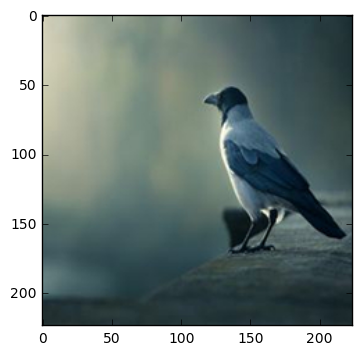

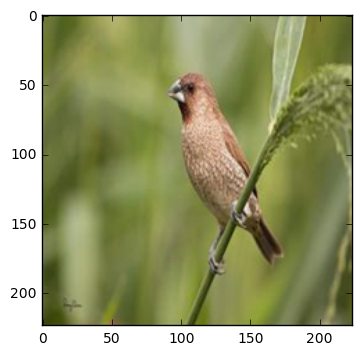

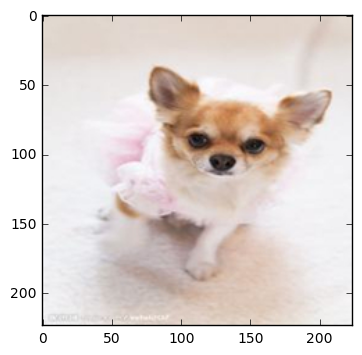

In [20]:
with tf.Session() as sess:
    #在迭代控制中,记得添加tf.initialize_local_variables(),官网教程没有说明,但是如过不加，会出错
    sess.run(init)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)
    
    y1,y2 = sess.run([image_batch, label_batch])
    coord.request_stop()
    coord.join(threads)

print(y1.shape)
plt.figure(0)
plt.imshow(y1[0])
plt.figure(1)
plt.imshow(y1[1])
plt.figure(2)
plt.imshow(y1[2])
pl.show()
